In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
from copy import deepcopy
from typing import Any

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from acnportal.acnsim.network.sites import caltech_acn, jpl_acn

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

MIN_ACTION = 0
MAX_ACTION = 4

period = 5
recompute_freq = 2
env = EVChargingEnv(site='caltech', date_range=["2018-11-07", "2018-11-07"], real_traces=True, period=5, recompute_freq=2)

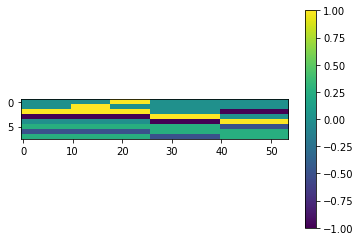

In [3]:
acn = caltech_acn()

plt.imshow(acn.constraint_matrix)
plt.colorbar()
plt.show()


In [4]:
observation = env.reset()

In [5]:
observation['magnitudes'] 

array([ 80.        ,  80.        , 416.66666667, 416.66666667,
       416.66666667, 180.50541516, 180.50541516, 180.50541516])

In [6]:
jpl_acn().max_pilot_signals

array([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32])

In [7]:
max(acn.min_pilot_signals)

8

In [8]:
demands = np.random.rand(54) * 30

In [9]:

r = cp.Variable(54, integer=True)

acn = caltech_acn()
A = acn.constraint_matrix
phase_factor = np.exp(1j * np.deg2rad(observation['phases']))
A_tilde = A * phase_factor[None, :]
agg_current_complex = A_tilde @ r
agg_magnitude = cp.abs(agg_current_complex)

demands = cp.Parameter(54)

objective = cp.Minimize(cp.norm(r - demands, p=1))
constraints = [0 <= r, r <= MAX_ACTION, agg_magnitude <= observation['magnitudes'] / 8]

prob = cp.Problem(objective, constraints)
print("Is DPP? ", prob.is_dcp(dpp=True))
print("Is DCP? ", prob.is_dcp(dpp=False))

demand_vals = [np.random.rand(54) * i for i in range(10)]
i = 0
for demand in demand_vals:
    i += 1
    print(i)
    demands.value = demand
    prob.solve(solver='ECOS_BB')



# print("Optimal value", prob.solve(solver='ECOS_BB'))
# print("Optimal var")
# print(r.value)

Is DPP?  True
Is DCP?  True
1
2
3
4
5
6
7
8
9
10


In [ ]:
from typing import Any

from sustaingym.envs.evcharging.actions import to_schedule, ACTION_DISCRETIZATION_FACTOR
from copy import deepcopy

MIN_ACTION = 0
MAX_ACTION = 4


class BaseOnlineAlgorithm:
    """
    Abstract base class meant to be inherited from to implement new algorithms.

    Subclasses must implement the schedule method.

    Attributes:
        env: EV Charging Environment
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        TODO comments
        Create a schedule of charging rates for each ev in the active_evs list.
        NOT IMPLEMENTED IN BaseAlgorithm. This method MUST be implemented in all
        subclasses.

        This method returns a schedule of charging rates for each
        Args:
            active_sessions (List[SessionInfo]): List of SessionInfo objects
                which are currently ready to be charged and not finished
                charging.
        Returns:
            Dict[str, List[float]]: Dictionary mapping a station_id to a list of
                charging rates. Each charging rate is valid for one period measured
                relative to the current period, i.e. schedule['abc'][0] is the
                charging rate for station 'abc' during the current period and
                schedule['abc'][1] is the charging rate for the next period,
                and so on. If an algorithm only produces charging rates for the
                current time period, the length of each list should be 1. If this is
                the case, make sure to also set the maximum resolve period to be 1
                period so that the algorithm will be called each period. An
                alternative is to repeat the charging rate a number of times equal to
                the max recompute period.
        """
        raise NotImplementedError
    
    def scale_obs(self, observation) -> dict[str: Any]:
        """
        Scale observation demand by the action discretization factor.

        Normalize demands so that action outputs in {0, 1, 2, 3, 4}
        can have the same magnitude impact on decreasing demands.
        """
        scaled_obs = observation.copy()
        scaled_obs['demands'] /= ACTION_DISCRETIZATION_FACTOR
        scaled_obs['magnitudes'] /= ACTION_DISCRETIZATION_FACTOR
        return scaled_obs

    def run(self, env: EVChargingEnv, iterations: int):
        """
        Runs the scheduling algorithm for the current period and returns the
        resulting reward.

        Args:
            iterations: Number of times to run and collect rewards

        Returns:
            See schedule.
        """
        env = deepcopy(env)
        total_rewards = []

        for _ in range(iterations):
            done = False
            options = {"verbose": 1}
            obs = env.reset(options=options)
            obs = self.scale_obs(obs)
            acc_reward = 0.0

            while not done:
                action = self.get_action(obs)
                obs, reward, done, _ = env.step(action)
                obs = self.scale_obs(obs)
                acc_reward += reward
            
            total_rewards.append(acc_reward)
        
        return total_rewards



class UncontrolledChargingAlgorithm(BaseOnlineAlgorithm):
    name = "selective max charge"
    """
    Algortihm that charges at the maximum rate allowed.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.where(observation["demands"] > 0, 4, 0)


class NoChargingAlgorithm(BaseOnlineAlgorithm):
    name = "no charge"
    """
    Algortihm that charges at the maximum rate allowed by environment.
    """
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        Charge at the maximum allowed rate by the gym for cars that
        have positive demands.
        """
        return np.zeros(shape=observation["demands"].shape)


class DumbAlgorithm(BaseOnlineAlgorithm):
    name = "constraint violator"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.ones(shape=observation["demands"].shape) * MAX_ACTION

class RandomAlgorithm(BaseOnlineAlgorithm):
    name = "random"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        return np.random.randint(5, size=observation["demands"].shape)

class GreedyAlgorithm(BaseOnlineAlgorithm):
    """
    Algorithm that charges at the maximum rate respecting network
    constraints.
    """
    name = "greedy"
    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        
        """
        pass

class RLAlgorithm(BaseOnlineAlgorithm):
    """
    Based on RL
    """
    def __init__(self, rl_model, name="RL algorithm"):
        self.rl_model = rl_model
        self.name = name

    def get_action(self, observation: dict[str, Any]) -> np.ndarray:
        """
        """
        return self.rl_model.predict(observation)[0]

In [ ]:
from datetime import datetime, timedelta
import pandas as pd

DATE_FORMAT = "%Y-%m-%d"

algs = [UncontrolledChargingAlgorithm(), NoChargingAlgorithm(), DumbAlgorithm(), RandomAlgorithm()]

def collect_rewards(env, algs):
    begin = datetime.strptime(date_range[0], DATE_FORMAT)
    end = datetime.strptime(date_range[1], DATE_FORMAT)
    days_diff = end - begin
    num_days_sim = days_diff.days + 1

    results = {}
    for alg in algs:
        results[alg] = alg.run(env, num_days_sim)
    results = {alg.name: reward for alg, reward in results.items()}

    results['dates'] = [begin + timedelta(days=i) for i in range(num_days_sim)]

    results = pd.DataFrame(results)
    results.set_index('dates', inplace=True)
    return results

date_range = ["2018-11-07", "2018-11-09"]
site = 'caltech'
eval_env = EVChargingEnv(site=site, date_range=date_range, real_traces=True, period=period, recompute_freq=recompute_freq)

rewards = collect_rewards(eval_env, algs)

Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 


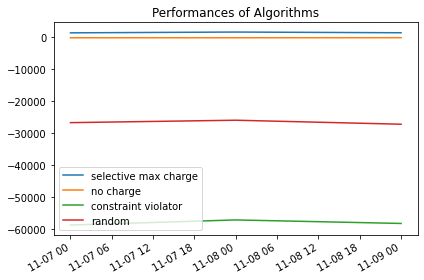

In [ ]:
plt.title("Performances of Algorithms")
for col in rewards.columns:
    plt.plot(rewards[col], label=col)
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rewards

,selective max charge,no charge,constraint violator,random
dates,,,,
2018-11-07,1431.09619,-108.953704,-58726.430027,-26675.707484
2018-11-08,1678.92414,-108.568519,-57124.640764,-25915.371565
2018-11-09,1456.96505,-90.009259,-58225.706817,-27166.761145


In [ ]:
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from sustaingym.envs.evcharging.ev_charging import EVChargingEnv

In [ ]:
train_env = EVChargingEnv('caltech', date_range, real_traces=False)
model = PPO('MultiInputPolicy', train_env, verbose=0)
rl_algo = RLAlgorithm(model)


--- Training GMMs ---

Fetching data from site caltech for date range 2018-11-07 2018-11-09... 
Fitting GMMs (50 components, 4 dimensions)... 
Creating directory:  sustaingym/envs/evcharging/gmms/caltech/2018-11-07 2018-11-09 50
Saving in:  sustaingym/envs/evcharging/gmms/caltech/2018-11-07 2018-11-09 50

GMM training complete. 



In [ ]:
untrained_rewards = collect_rewards(eval_env, [rl_algo])
untrained_rewards

Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 


,RL algorithm
dates,
2018-11-07,-27492.379126
2018-11-08,-26370.159239
2018-11-09,-26746.648012


In [ ]:
trained_rewards = {}
num_steps = 0
timesteps = 25_000

for _ in range(10):
    num_steps += timesteps
    model.learn(total_timesteps=timesteps)
    print("num timesteps: ", num_steps)
    trained_rewards[num_steps] = collect_rewards(eval_env, [rl_algo])
    display(trained_rewards[num_steps])

model learned
Simulating day 2018-11-07 with 36 plug in events. 
Simulating day 2018-11-08 with 46 plug in events. 
Simulating day 2018-11-09 with 42 plug in events. 


,RL algorithm
dates,
2018-11-07,-27429.058868
2018-11-08,-26546.479595
2018-11-09,-26109.946579


KeyboardInterrupt: 